In [43]:
import warnings
warnings.filterwarnings("ignore")
import string
import re
from unicodedata import normalize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from string import punctuation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from nltk.translate.bleu_score import corpus_bleu
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

In [44]:
total_sentences = 10000

dataset = pd.read_csv('./eng_-french.csv/eng_-french.csv')

test_proportion = 0.1
train_test_threshold = int((1-test_proportion)*total_sentences)

printmd(f'## {total_sentences} "parallel sentences will be loaded (original sentence + its translation)"')
printmd(f'## {train_test_threshold} "parallel sentences" will be used to train the model')
printmd(f'## {total_sentences-train_test_threshold} "parallel sentences" will be used to test the model')

## 10000 "parallel sentences will be loaded (original sentence + its translation)"

## 9000 "parallel sentences" will be used to train the model

## 1000 "parallel sentences" will be used to test the model

In [45]:
dataset = dataset.sample(frac = 1, random_state = 0)
dataset.iloc[1000:1010]


,English words/sentences,French words/sentences
35664,I want to go to Mars.,Je veux me rendre sur Mars.
11476,I'm not patient.,Je ne suis pas patient.
16900,We'll never know.,Nous ne le saurons jamais.
21719,We've made a deal.,Nous avons passé un accord.
60740,I bought a book of jokes.,J'ai acheté un livre de blagues.
87850,Are you sure it's impossible?,Êtes-vous sûres que c'est impossible ?
56665,That dog is really ugly.,Ce chien est vraiment laid.
169395,Quite a few people were present at the meeting...,Pas mal de gens étaient présents à la réunion ...
80458,"You like Boston, don't you?","Tu aimes Boston, pas vrai ?"
161969,I don't think we should be talking to each other.,Je ne pense pas que nous devrions nous parler.


In [46]:
def clean(string):
    string = string.replace("\u202f"," ")
    string = string.lower()

    for p in punctuation + "«»" + "0123456789":
        string = string.replace(p," ")

    string = re.sub('\s+',' ',string)
    string = string.strip()

    return string

dataset["English words/sentences"] = dataset["English words/sentences"].apply(lambda x: clean(x))
dataset["French words/sentences"] = dataset["French words/sentences"].apply(lambda x: clean(x))

dataset = dataset.values
dataset = dataset[:total_sentences]

train, test = dataset[:train_test_threshold], dataset[train_test_threshold:]

source_str, target_str = "French", "English"

idx_src, idx_tar = 1, 0
pd.DataFrame(dataset[1000:1010])

,0,1
0,i want to go to mars,je veux me rendre sur mars
1,i m not patient,je ne suis pas patient
2,we ll never know,nous ne le saurons jamais
3,we ve made a deal,nous avons passé un accord
4,i bought a book of jokes,j ai acheté un livre de blagues
5,are you sure it s impossible,êtes vous sûres que c est impossible
6,that dog is really ugly,ce chien est vraiment laid
7,quite a few people were present at the meeting...,pas mal de gens étaient présents à la réunion ...
8,you like boston don t you,tu aimes boston pas vrai
9,i don t think we should be talking to each other,je ne pense pas que nous devrions nous parler


In [47]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def max_len(lines):
    return max(len(line.split()) for line in lines)

def encode_sequences(tokenizer,length,lines):
    X = tokenizer.texts_to_sequences(lines)
    X = pad_sequences(X, maxlen=length,padding='post')
    return X

def encode_output(sequences,vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence,num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

tar_tokenizer = create_tokenizer(dataset[:,idx_tar])
tar_vocab_size = len(tar_tokenizer.word_index)+1
tar_length = max_len(dataset[:, idx_tar])
printmd(f'\nTarget ({target_str}) Vocabulary Size: {tar_vocab_size}')
printmd(f"Target ({target_str}) Max Length: {tar_length}")

src_tokenizer = create_tokenizer(dataset[:,idx_src])
src_vocab_size = len(src_tokenizer.word_index)+1
src_length = max_len(dataset[:, idx_src])
printmd(f'\nSource ({source_str}) Vocabulary Size: {src_vocab_size}')
printmd(f'Source ({source_str}) Max Length: {src_length}\n')

trainX = encode_sequences(src_tokenizer,src_length,train[:,idx_src])
trainY = encode_sequences(tar_tokenizer,tar_length,train[:,idx_tar])
trainY = encode_output(trainY,tar_vocab_size)

testX = encode_sequences(src_tokenizer,src_length,test[:, idx_src])
testY = encode_sequences(tar_tokenizer, tar_length, test[:, idx_tar])
testY = encode_output(testY, tar_vocab_size)


Target (English) Vocabulary Size: 4644

Target (English) Max Length: 39


Source (French) Vocabulary Size: 6708

Source (French) Max Length: 50


In [48]:
def create_model(src_vocab ,tar_vocab, src_timestamps, tar_timestamps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timestamps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timestamps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model

model = create_model(src_vocab_size, tar_vocab_size, src_length, tar_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
history = model.fit(trainX,
                    trainY,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[
                        EarlyStopping(
                            monitor='val_loss',
                            patience=10,
                            restore_best_weights=True
                        )
                    ])


Epoch 1/20
127/127 [==============================] - 161s 1s/step - loss: 1.8843 - val_loss: 1.1606
Epoch 2/20
127/127 [==============================] - 191s 2s/step - loss: 1.1399 - val_loss: 1.1408
Epoch 3/20
127/127 [==============================] - 243s 2s/step - loss: 1.1381 - val_loss: 1.1752
Epoch 4/20
127/127 [==============================] - 250s 2s/step - loss: 1.0539 - val_loss: 1.0604
Epoch 5/20
127/127 [==============================] - 239s 2s/step - loss: 1.0168 - val_loss: 1.0586
Epoch 6/20
127/127 [==============================] - 248s 2s/step - loss: 1.0048 - val_loss: 1.0541
Epoch 7/20
127/127 [==============================] - 244s 2s/step - loss: 0.9973 - val_loss: 1.0553
Epoch 8/20
127/127 [==============================] - 241s 2s/step - loss: 0.9873 - val_loss: 1.0541
Epoch 9/20
127/127 [==============================] - 248s 2s/step - loss: 0.9807 - val_loss: 1.0626
Epoch 10/20
127/127 [==============================] - 243s 2s/step - loss: 0.9743 - val_lo

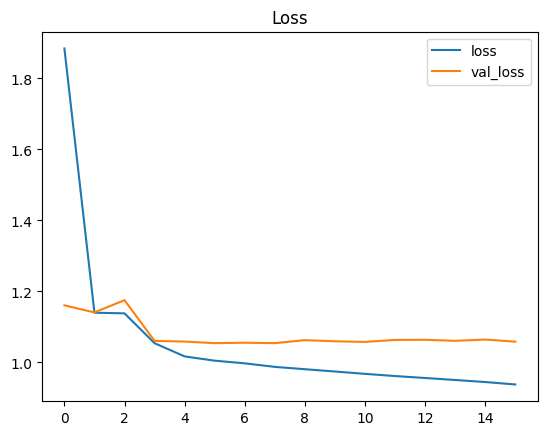

In [49]:
pd.DataFrame(history.history).plot()
plt.title('Loss')
plt.show()

In [50]:
def word_for_id(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_seq(model, tokenizer, source):
    prediction = model.predict(source,verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    actual, predicted = [], []
    src = f'{source_str.upper()} (Source)'
    tgt = f'{target_str.upper()} (Target)'
    pred = f'Automatic translation in {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')

    for i, source in enumerate(sources):
        source = source.reshape((1,source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit:
            break

print('### Result on the Training Set ###')
compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
compare_prediction(model, tar_tokenizer, testX, test)


### Result on the Training Set ###
FRENCH (Source)                ENGLISH (Target)          Automatic translation in ENGLISH

nous changeons toutes          we all change             i you
je ne suis pas cynique à ce point là i m not that cynical      i you you to
j aimerais te dire quelque chose en privé i d like to tell you something in private i you you to to to
le restaurant était loin de la gare the restaurant was far from the train station i you you to to
tom ne sait pas où marie a l habitude d aller skier tom doesn t know where mary usually goes skiing i you you to to to to
je ne veux pas perdre mary     i don t want to lose mary i you you to to
elle est partie                she went out              i you you
quel est le nom de ton petit copain what s your boyfriend s name i you you to
nous n allons pas arrêter maintenant we re not going to stop now i you you to to
j étais insouciant             i was careless            i you
je suis désolée d avoir raté ton anniversaire i m 

In [51]:
def bleu_score(model, tokenizer, sources, raw_dataset):
    actual, predicted = [], []
    for i, source in enumerate(sources):
        source = source.reshape((1,source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        actual.append([raw_target.split()])
        predicted.append(translation.split())

    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0,0,0,0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    return bleu_dic

bleu_train = bleu_score(model, tar_tokenizer, trainX, train)
bleu_test = bleu_score(model, tar_tokenizer, testX, test)

plt.bar(x = bleu_train.keys(), height = bleu_train.values())
plt.title("BLEU score with the training set")
plt.ylim((0,1))
plt.show()

KeyboardInterrupt: 

In [ ]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the test set")
plt.ylim((0,1))
plt.show()